# How does bike-sharing service substitute for subway transit? A geospatial perspective in New York City

*Jiaxuan Tang and Muwen He, Final project for CRP5680*

In [254]:
import os
import pandas as pd
import geopandas as gpd
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
import contextily as ctx
from datetime import datetime
import time
import numpy as np
from shapely import geometry
from pysal.lib import weights
from pysal.explore import esda
import contextily

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/tangjiaxuan/opt/anaconda3/envs/gds_py_ARM/lib/python3.9/site-packages/spaghetti/network.py:39: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


## Abstract

共享自行车服务长久以来被认为是地铁等公共交通的互补品，用以补充所谓“最后一公里”。但实际的经验表明，在公共交通高度发达的城市中，共享自行车服务也可能作为替代地铁等出行方式的另一种选择。本文基于纽约市2022年9月的Citibike订单数据和MTA转门数据进行分析，通过一个多级别筛选模型识别Citibike订单中与地铁具有替代效应的订单所占的比例作为替代指数，以衡量全市范围（Citibike服务范围）内共享单车对地铁替代率。在时间层面上，本文计算了共享单车替代率在一天24小时之内的分布。在空间层面上，本文识别了替代率在纽约市不同地区的分布情况，并同归包含空间因素的回归模型探讨了影响替代率的社会经济因素。
Bike-sharing services have long been promoted to complement public transportation systems like the subway, bridging the "last mile" theory. However, experience suggests that bike-sharing services can also emerge as an alternative choice in cities with highly developed public transportation, substituting subway travel. This article analyzes Citibike service data and MTA turnstile data from September 2022 in New York City. Through a multi-level filtering model, we identify the proportion of Citibike orders that show a substitutive effect with the subway. We use the proportion as a substitution index to measure the city-wide (within Citibike's service range) rate of bike-sharing substitution for the subway. From a spatial perspective, we pinpoint the distribution of the substitution rate across different regions in New York City and examine the socioeconomic factors influencing this rate using a regression model that includes spatial elements. In terms of time, we calculate the distribution of the bike-sharing substitution rate within 24 hours.

结果表明，

**Key Words:**

## Primary Question

1. Is there a complementary relationship or a substitution relationship between bike-sharing and subway transit in NYC?
2. If so, on a geographical scale, what characteristics of the neighborhood will influence this relationship?

## 1. Introduction and Background

Affordable and flexible, bicycle-sharing provides an additional option for users and is widely used globally (DeMaio, 2009). Beyond serving as a form of public transportation, bike-sharing is also a means of addressing the "last mile" problem, extending the services of existing public transit modes. Therefore, its relationship with other public transportation systems should be considered when studying bike-sharing. Based on studies across different cities, opinions vary on whether bike-sharing services complement or substitute for public transit like subways. Conclusions are influenced by multiple factors such as urban environment, characteristics of the public transit system, features of the bike-sharing system, and resident habits (Qian et al., 2023; Martin & Xu, 2022; Soto Padin, 2018; Basak & Iris, 2023). Due to significant differences between cities, the specific relationship must be studied based on actual circumstances.

Moreover, few studies mention which factors are influencing this relationship. Most of the existing studies focus on (1) modeling bike-sharing usage based on individual influences such as weather, including using machine learning approaches (AitBihiOuali & Klingen, 2022; Hamad et al., 2021; Wang, 2016; Xin et al., 2023); (2) analyzing spatial characteristics of bike-sharing usage, including time and space lag effects (Faghih-Imani & Eluru, 2016); (3) discussion of how to locate the bike-sharing stations (Mix et al., 2022); (4) bike-sharing and user motivation (Bartling, 2022); and (5) some other topics of the characteristics of the system itself (Zhang et al., 2022).

Using New York City as a case study and data from Citi Bike in New York, this paper explores the relationship between bike-sharing and subway systems, as a substitute or complement, in cities with highly developed public transportation. We will answer two questions: 1) Is there a complementary or substitutive relationship between bike-sharing and subway transit in New York City? 2) If so, at the geographical scale, which neighborhood characteristics affect this relationship?

## 2. Data and Methodology


### 2.1 Methods



<img src="Image/1-s2.0-S0966692319304934-gr2.jpg" alt="drawing" width="600" style="display: block; margin: 0 auto"/>
</figure>

### 2.2 Study Area
New York City incorporates five boroughs: Bronx, Brooklyn, Manhattan, Queens, and Staten Island. As a premier metropolis, NYC has been a guide to other cities in many areas of development, including, but not limited to, urban planning, transportation, and the economy. Commuters in NYC heavily rely on the most extensive integrated public transit system in the U.S., Metropolitan Transportation Authority (MTA), encompassing buses, subways, and commuter rails. A maximum of 10% of trips are made by private car as a result of existing transit-oriented infrastructure and policies in NYC (NYC Department of Transportation, 2019). Bike-sharing has gained increasing popularity with the thriving sharing economy. Citi Bike has snowballed in New York City since 2013 and covers all of Manhattan, including Central Park, Western Queens, and Northwest Brooklyn. The study area for this report is further limited based on the service area of Citibike on September 2022. 


#### 2.2.1 Deciding the Study Area Using CitiBike Docking Service Area
Here we have two steps:
1. Generate a list of active docks of the month using the citibike operating data.
2. Create a buffer of walking distance around each dock showcasing the service area.

In [255]:
### Read the citibike usage data of Sep 2022
### more information: https://citibikenyc.com/system-data 
df = pd.read_csv('Data/Citibike/Citibike_2022_Sep_RAW/202209-citibike-tripdata.csv',low_memory=False)

In [256]:
### Take a look at the columns
df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')

In [257]:
### This section is to find locations of all citibike docks. The locations are to draw buffers for further analysis.
### We will use start locations since we find some of the end locations be in New Jersey (the start location shall cover all the active docks)

### drop unnecessary columns
### drop NaNs
start = df.drop(columns=['ride_id', 'rideable_type','started_at', 
                          'ended_at','end_station_name','end_station_id',
                          'end_lat', 'end_lng', 'member_casual']).dropna()

In [259]:
### Rename the columns making it easier to read
start = start.rename(columns = {'start_station_name':"station_name",
                                'start_station_id':"station_id",
                                'start_lat':"Latitude",
                                'start_lng':"Longitude"})
                                
start.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3507123 entries, 0 to 3507122
Data columns (total 4 columns):
 #   Column        Dtype  
---  ------        -----  
 0   station_name  object 
 1   station_id    object 
 2   Latitude      float64
 3   Longitude     float64
dtypes: float64(2), object(2)
memory usage: 107.0+ MB


In [260]:
### Drop duplicated stations for shorter responding time
citi_stations = start.drop_duplicates('station_name')
citi_stations

,station_name,station_id,Latitude,Longitude
0,Henry St & Degraw St,4380.08,40.684736,-73.999088
1,6 Ave & W 34 St,6364.10,40.749640,-73.988050
3,48 St & 5 Ave,3202.06,40.646351,-74.009271
4,Steinway St & Ditmars Blvd,7074.01,40.772621,-73.906240
5,1 Ave & E 62 St,6753.08,40.761305,-73.960684
...,...,...,...,...
1792531,46 St & 7 Ave,3117.05,40.644791,-74.003776
1792619,76 St & 21 Ave,7032.02,40.770234,-73.893697
1837802,Decatur Ave & E 197 St,8597.01,40.865823,-73.887657
1867320,Boerum Pl\t& Pacific St,4488.09,40.688489,-73.991160


In [264]:
### Turn the citibike data into geodata frame, then re-project it to PCS EPSG = 2263 (NAD83 / New York Long Island (ftUS))
citi_stations_geom = gpd.GeoDataFrame(citi_stations, 
                               geometry=gpd.points_from_xy(citi_stations.Longitude, citi_stations.Latitude), 
                               crs="EPSG:4326")
citi_stations_geom = citi_stations_geom.to_crs(epsg=2263)

In [265]:
### Make the geometries
### Since we used 1320 feet for walk distance (1/4 mile)
buffer_geom = citi_stations_geom['geometry'].buffer(1320)

### Second, we already know the CRS
### This the same as the CRS of public housing data 
buffer_crs = citi_stations_geom.crs

### Now, let's put it all together using the GeoDataFrame constructor
buffer = gpd.GeoDataFrame(citi_stations_geom, crs=buffer_crs, geometry=buffer_geom)

<AxesSubplot: >

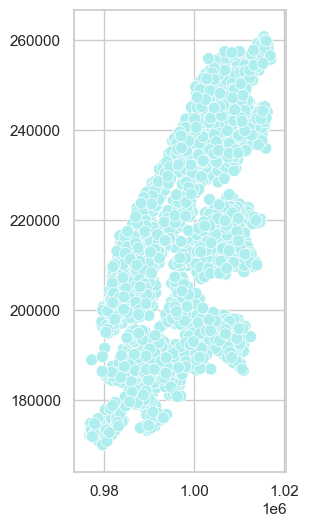

In [266]:
### Plot the buffer to eyeball it
buffer.plot(figsize=(6,6),
            facecolor = "paleturquoise", 
            edgecolor = "white",
            lw = 0.5)

#### 2.2.2 Create a Fishnet And Assign PLUTO Data For Future Steps

##### a. Create the Fishnet
Here we have two steps:
1. Create a fishnet accourding to the max longitute and max lagitute of Citibike doce service area.
2. Filter the fishnet to keep only area intersects to the Citibike Doce Service Area.

In [273]:
### Create a fishnet

### Get the extent of the geom
total_bounds = buffer.total_bounds
 
### Get minX, minY, maxX, maxY
minX, minY, maxX, maxY = total_bounds
 
### Create a fishnet
x, y = (minX, minY)
geom_array = []
 
    # Polygon Size
square_size = 1320
while y <= maxY:
    while x <= maxX:
        geom = geometry.Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
        geom_array.append(geom)
        x += square_size
    x = minX
    y += square_size
 
fishnet = gpd.GeoDataFrame(geom_array, columns=['geometry']).set_crs('EPSG:2263')

<AxesSubplot: >

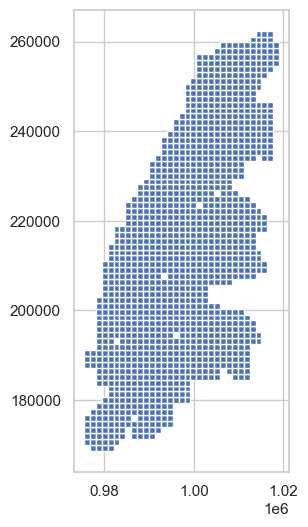

In [274]:
### Spatial join the buffer to fishnet
### We want to only keep grids that intersect to citibike service area
fishnet_crop = gpd.sjoin(fishnet, 
                         buffer, 
                         how="left", 
                         op='intersects')

### drop NaN and keep one grid at a location
fishnet_crop = fishnet_crop.dropna().drop_duplicates('geometry')

### take a look
fishnet_crop.plot(figsize=(6,6))

In [275]:
### Drop unnecessary columns for future analysis
fishnet_crop = fishnet_crop.drop(columns=['index_right','station_name', 'station_id', 'Latitude', 'Longitude'])
fishnet_crop.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1307 entries, 1 to 2341
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  1307 non-null   geometry
dtypes: geometry(1)
memory usage: 20.4 KB


##### b. Assign Lot Information from PLUTO
Two Steps:
1. Import MapPLUTO data that contains extensive land use and geographic data at the tax lot level. More information can be found at: https://www.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page.
2. Spatial join MapPLUTO to fishnet.

In [276]:
### Read the MapPLUTO data
pluto = gpd.read_file('Data/PLUTO/nyc_mappluto_22v2_arc_shp.zip')

In [277]:
### Drop unnecessary columns for shorter responding time
pluto_clean = pluto.drop(columns=['Borough', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010',
                           'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct',
                           'HealthCent', 'HealthArea', 'Sanitboro', 'SanitDistr', 'SanitSub',
                           'Address', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4',
                           'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight',
                           'SplitZone', 'BldgClass', 'LandUse', 'Easements', 'OwnerType',
                           'OwnerName', 'AreaSource', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode',
                           'IrrLotCode', 'LotType', 'BsmtCode','YearBuilt', 'YearAlter1','LotFront','LotDepth', 
                           'YearAlter2', 'HistDist', 'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode',
                           'BBL', 'CondoNo', 'Tract2010', 'XCoord', 'YCoord', 'ZoneMap', 'ZMCode',
                           'Sanborn', 'TaxMap', 'EDesigNum', 'APPBBL', 'APPDate', 'PLUTOMapID',
                           'FIRM07_FLA', 'PFIRM15_FL', 'Version', 'DCPEdited', 'Notes', 'Shape_Leng', 'Shape_Area'])

In [278]:
### Calculate for the centroid
### We want to use centroids as reference to assign lots to each grid 
pluto_clean['centroid'] = pluto_clean.centroid

### Make sure we are using crs 2263
pluto_clean.crs

<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [279]:
### Use the calculated centroid point as geometry
pluto_clean = pluto_clean.drop(columns='geometry').rename(columns={'centroid':"geometry"})

In [280]:
### Spatial join mapPLUTO data to fishnet
soci = gpd.sjoin(fishnet_crop, 
                 pluto_clean, 
                 how="left", 
                 op='contains')
soci.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 207926 entries, 1 to 2341
Data columns (total 21 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   geometry     207926 non-null  geometry
 1   index_right  207817 non-null  float64 
 2   LotArea      207817 non-null  float64 
 3   BldgArea     207817 non-null  float64 
 4   ComArea      207817 non-null  float64 
 5   ResArea      207817 non-null  float64 
 6   OfficeArea   207817 non-null  float64 
 7   RetailArea   207817 non-null  float64 
 8   GarageArea   207817 non-null  float64 
 9   StrgeArea    207817 non-null  float64 
 10  FactryArea   207817 non-null  float64 
 11  OtherArea    207817 non-null  float64 
 12  NumBldgs     207817 non-null  float64 
 13  NumFloors    207817 non-null  float64 
 14  UnitsRes     207817 non-null  float64 
 15  UnitsTotal   207817 non-null  float64 
 16  AssessLand   207817 non-null  float64 
 17  AssessTot    207817 non-null  float64 
 18

In [281]:
### Accouding to index, which represents to each grid in the fishnet
### Sum up each type of areas, building numbers, number of floors, 
### Number fo uites, assess and exempt for future analysis
soci['id'] = soci.index
soci_sum = soci.groupby('id')['LotArea', 'BldgArea', 'ComArea', 'ResArea',
                            'OfficeArea', 'RetailArea', 'GarageArea', 'StrgeArea', 
                            'FactryArea','OtherArea', 'NumBldgs', 'NumFloors', 
                            'UnitsRes', 'UnitsTotal','AssessLand', 'AssessTot', 'ExemptTot'].sum()
soci_sum.head(3)

,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,NumBldgs,NumFloors,UnitsRes,UnitsTotal,AssessLand,AssessTot,ExemptTot
id,,,,,,,,,,,,,,,,,
1,1146344.0,1936003.0,268741.0,1502615.0,105768.0,50741.0,0.0,0.0,0.0,112232.0,423.0,932.00,1622.0,1753.0,14948236.0,83827602.0,10628703.0
2,1190884.0,1714462.0,307504.0,1304381.0,35180.0,115073.0,0.0,0.0,0.0,156275.0,582.0,1034.33,1359.0,1472.0,12682487.0,87064026.0,10102326.0
3,805486.0,798611.0,90167.0,696324.0,6973.0,48445.0,15641.0,0.0,16900.0,0.0,351.0,564.00,754.0,794.0,9343800.0,43618620.0,3698208.0


In [286]:
### Join the summed mapPLUTO data back to fishnet
soci_final = fishnet_crop.merge(soci_sum,
                                left_index=True,
                                right_on='id',how='left')
                                
soci_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1307 entries, 1 to 2341
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geometry    1307 non-null   geometry
 1   LotArea     1307 non-null   float64 
 2   BldgArea    1307 non-null   float64 
 3   ComArea     1307 non-null   float64 
 4   ResArea     1307 non-null   float64 
 5   OfficeArea  1307 non-null   float64 
 6   RetailArea  1307 non-null   float64 
 7   GarageArea  1307 non-null   float64 
 8   StrgeArea   1307 non-null   float64 
 9   FactryArea  1307 non-null   float64 
 10  OtherArea   1307 non-null   float64 
 11  NumBldgs    1307 non-null   float64 
 12  NumFloors   1307 non-null   float64 
 13  UnitsRes    1307 non-null   float64 
 14  UnitsTotal  1307 non-null   float64 
 15  AssessLand  1307 non-null   float64 
 16  AssessTot   1307 non-null   float64 
 17  ExemptTot   1307 non-null   float64 
dtypes: float64(17), geometry(1)
memory usage

### 2.3 Data Wrangling


#### 2.3.1 Processing MTA Turnstile Data
We use...

##### a. Importing MTA Turnstile Data

In [189]:
### We create an empty DataFrame to store the data, and combine all the csv files in the root folder as one single DataFrame
mta = pd.DataFrame(data=None)
mta_root = "Data/MTA/2022_Sep_Raw/"
for item in os.listdir(mta_root):
    if not item.startswith('.') and os.path.isfile(os.path.join(mta_root, item)):
        mta = pd.concat([mta, pd.read_csv('Data/MTA/2022_Sep_Raw/'+item)])

In [190]:
### Take a look at the data
mta.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2022,00:00:00,REGULAR,7764183,2740761
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2022,04:00:00,REGULAR,7764199,2740765
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2022,08:00:00,REGULAR,7764207,2740786
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2022,12:00:00,REGULAR,7764258,2740854
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2022,16:00:00,REGULAR,7764341,2740900


In [191]:
### Reanme the columns to prevent potential bugs
mta.columns = ['C/A', 'Unit', 'Scp', 'Station', 'Linename', 'Division', 'Date', 'Time', 'Desc', 'Entries', 'Exits']
mta.head()

,C/A,Unit,Scp,Station,Linename,Division,Date,Time,Desc,Entries,Exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2022,00:00:00,REGULAR,7764183,2740761
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2022,04:00:00,REGULAR,7764199,2740765
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2022,08:00:00,REGULAR,7764207,2740786
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2022,12:00:00,REGULAR,7764258,2740854
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2022,16:00:00,REGULAR,7764341,2740900
...,...,...,...,...,...,...,...,...,...,...,...
212443,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/01/2022,01:00:00,REGULAR,0,804
212444,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/01/2022,05:00:00,REGULAR,0,804
212445,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/01/2022,07:45:47,REGULAR,0,804
212446,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/01/2022,09:00:00,REGULAR,0,804


##### b. Data cleaning: Processing Exit/Entrance Counts and Time

In [192]:
### Define a custom function to convert date and time in string format into local-time-zone timestamp
def date_convert(date_to_convert):
     return time.mktime(datetime.strptime(date_to_convert, "%m/%d/%Y %H:%M:%S").timetuple())

In [193]:
### Extract the date and time string as dt
dt = mta['Date'] + ' ' + mta['Time']

0         09/17/2022 00:00:00
1         09/17/2022 04:00:00
2         09/17/2022 08:00:00
3         09/17/2022 12:00:00
4         09/17/2022 16:00:00
                 ...         
212443    09/01/2022 01:00:00
212444    09/01/2022 05:00:00
212445    09/01/2022 07:45:47
212446    09/01/2022 09:00:00
212447    09/01/2022 13:00:00
Length: 1057508, dtype: object

In [194]:
### Create a new column to store the timestamp
mta['Timestamp'] = dt.apply(date_convert)

,C/A,Unit,Scp,Station,Linename,Division,Date,Time,Desc,Entries,Exits,Timestamp
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2022,00:00:00,REGULAR,7764183,2740761,1.663387e+09
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2022,04:00:00,REGULAR,7764199,2740765,1.663402e+09
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2022,08:00:00,REGULAR,7764207,2740786,1.663416e+09
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2022,12:00:00,REGULAR,7764258,2740854,1.663430e+09
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2022,16:00:00,REGULAR,7764341,2740900,1.663445e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
212443,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/01/2022,01:00:00,REGULAR,0,804,1.662008e+09
212444,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/01/2022,05:00:00,REGULAR,0,804,1.662023e+09
212445,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/01/2022,07:45:47,REGULAR,0,804,1.662033e+09
212446,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/01/2022,09:00:00,REGULAR,0,804,1.662037e+09


In [195]:
### Sorting records by multi-level criteria to ensure that each turnstile's records are in chronological order, and then re-index the whole dataframe to store this order
mta = mta.sort_values(by=['Station','C/A','Scp','Timestamp'],ascending=(True, True,True, True))
mta.reset_index(drop=True, inplace=True)
mta

,C/A,Unit,Scp,Station,Linename,Division,Date,Time,Desc,Entries,Exits,Timestamp
0,H007,R248,00-00-00,1 AV,L,BMT,08/27/2022,00:00:00,REGULAR,15825817,18930698,1.661573e+09
1,H007,R248,00-00-00,1 AV,L,BMT,08/27/2022,04:00:00,REGULAR,15825825,18930866,1.661587e+09
2,H007,R248,00-00-00,1 AV,L,BMT,08/27/2022,05:02:22,REGULAR,15825827,18930875,1.661591e+09
3,H007,R248,00-00-00,1 AV,L,BMT,08/27/2022,05:03:42,REGULAR,15825827,18930875,1.661591e+09
4,H007,R248,00-00-00,1 AV,L,BMT,08/27/2022,05:05:04,REGULAR,15825827,18930875,1.661591e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
1057503,R419,R326,00-05-01,ZEREGA AV,6,IRT,09/30/2022,05:00:00,REGULAR,39,289,1.664528e+09
1057504,R419,R326,00-05-01,ZEREGA AV,6,IRT,09/30/2022,09:00:00,REGULAR,39,289,1.664543e+09
1057505,R419,R326,00-05-01,ZEREGA AV,6,IRT,09/30/2022,13:00:00,REGULAR,39,289,1.664557e+09
1057506,R419,R326,00-05-01,ZEREGA AV,6,IRT,09/30/2022,17:00:00,REGULAR,39,289,1.664572e+09


In [196]:
'''
Use a single-tier loop to calculate the turnstile entry/exit numbers from the original cumulative records.
As we have already re-indexed the records, we can do the following thing in the loop:
If the one row matches the 'Station' , 'C/A' and 'Scp' column of its above row, then we can say it's from the same turnstile,
    therefore we subtract the number of the previous row from the number of that row to get the entery/exit counts in that time interval (four hours).
If any one of the four columns mentioned above doesn't match, that means this row is a starting row belonging to a new turnstile,
    therefore we do not do the calculation (we will do it later),
    and record this row's index in 'start_index' to help us find these starting rows more easily in the following steps.
'''
start_index = np.array([0])
for i in mta.index[1:len(mta.index)]:
    if((mta.loc[i,'Station']==mta.loc[i-1,'Station']) & (mta.loc[i,'C/A']==mta.loc[i-1,'C/A']) & (mta.loc[i,'Scp']==mta.loc[i-1,'Scp'])):
        mta.loc[i,'Entries_n'] = mta.loc[i,'Entries'] - mta.loc[i-1,'Entries']
        mta.loc[i,'Exits_n'] = mta.loc[i,'Exits'] - mta.loc[i-1,'Exits']
    else:
        start_index = np.append(start_index, i)

In [197]:
### One more steps for the starting rows: we let them be 0, because we don't have the data in their time interval
### (this acually doesn't matter since the records starts in late August and we will drop these rows to keep jest the record in September)
for i in start_index:
    mta.loc[i,'Entries_n'] = 0
    mta.loc[i,'Exits_n'] = 0
mta

,C/A,Unit,Scp,Station,Linename,Division,Date,Time,Desc,Entries,Exits,Timestamp,Entries_n,Exits_n
0,H007,R248,00-00-00,1 AV,L,BMT,08/27/2022,00:00:00,REGULAR,15825817,18930698,1.661573e+09,0.0,0.0
1,H007,R248,00-00-00,1 AV,L,BMT,08/27/2022,04:00:00,REGULAR,15825825,18930866,1.661587e+09,8.0,168.0
2,H007,R248,00-00-00,1 AV,L,BMT,08/27/2022,05:02:22,REGULAR,15825827,18930875,1.661591e+09,2.0,9.0
3,H007,R248,00-00-00,1 AV,L,BMT,08/27/2022,05:03:42,REGULAR,15825827,18930875,1.661591e+09,0.0,0.0
4,H007,R248,00-00-00,1 AV,L,BMT,08/27/2022,05:05:04,REGULAR,15825827,18930875,1.661591e+09,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057503,R419,R326,00-05-01,ZEREGA AV,6,IRT,09/30/2022,05:00:00,REGULAR,39,289,1.664528e+09,0.0,0.0
1057504,R419,R326,00-05-01,ZEREGA AV,6,IRT,09/30/2022,09:00:00,REGULAR,39,289,1.664543e+09,0.0,0.0
1057505,R419,R326,00-05-01,ZEREGA AV,6,IRT,09/30/2022,13:00:00,REGULAR,39,289,1.664557e+09,0.0,0.0
1057506,R419,R326,00-05-01,ZEREGA AV,6,IRT,09/30/2022,17:00:00,REGULAR,39,289,1.664572e+09,0.0,0.0


In [198]:
### Get the absolute number of all the entry/exit records, since some turnstiles will downcount 1 for everytime usage (the opposite to most of the others)
mta['Entries_n'] = abs(mta['Entries_n'])
mta['Exits_n'] = abs(mta['Exits_n'])

In [199]:
### Remove extreme values, these values appear because of hardware failure or limitation.
### We set the threshold to 10000 in four hours according to Chirs Wong: https://medium.com/qri-io/taming-the-mtas-unruly-turnstile-data-c945f5f96ba0
mta = mta[(mta['Entries_n']<=10000) & (mta['Exits_n']<=10000)]

In [200]:
### Trick: Export the mta data to a CSV file. You can re-read it in the cell below if the data wrangling steps take too long to run!
mta.to_csv('Data/MTA/MTA_ALL_RAW.csv',index=False)

In [209]:
### Read the exported file (as if nothing has happened!)
mta = pd.read_csv('Data/MTA/MTA_ALL_RAW.csv')

,C/A,Unit,Scp,Station,Linename,Division,Date,Time,Desc,Entries,Exits,Timestamp,Entries_n,Exits_n
0,H007,R248,00-00-00,1 AV,L,BMT,08/27/2022,00:00:00,REGULAR,15825817,18930698,1.661573e+09,0.0,0.0
1,H007,R248,00-00-00,1 AV,L,BMT,08/27/2022,04:00:00,REGULAR,15825825,18930866,1.661587e+09,8.0,168.0
2,H007,R248,00-00-00,1 AV,L,BMT,08/27/2022,05:02:22,REGULAR,15825827,18930875,1.661591e+09,2.0,9.0
3,H007,R248,00-00-00,1 AV,L,BMT,08/27/2022,05:03:42,REGULAR,15825827,18930875,1.661591e+09,0.0,0.0
4,H007,R248,00-00-00,1 AV,L,BMT,08/27/2022,05:05:04,REGULAR,15825827,18930875,1.661591e+09,0.0,0.0


In [213]:
### Divide 4-hour intervals into 4 one-hour intervels.
### CAUTION: To reduce the computational pressure, here we make them in to four different DataFrames. We will merge them in the very last step.
### Here, time_interval = 3600 equals to one hour. We also divide the counts in every four-hour interval evenly into the four one-hour intervals.
### This is meaningful because although all the original intervals are four hours, but they are not divided with the same time point (to avoid huge data flow to the system).
time_interval = 3600
mta.loc[:,'Exits_n'] = mta.loc[:,'Exits_n']/4
mta.loc[:,'Entries_n'] = mta.loc[:,'Entries_n']/4

mta_1 = mta.copy(deep=True)
mta_2 = mta.copy(deep=True)
mta_3 = mta.copy(deep=True)
mta_1['Timestamp'] = mta_1['Timestamp'] - time_interval * 1
mta_2['Timestamp'] = mta_2['Timestamp'] - time_interval * 2
mta_3['Timestamp'] = mta_3['Timestamp'] - time_interval * 3

In [211]:
### Drop Weekends: we only study the weekdays
mta = mta[(mta['Timestamp'].apply(lambda x: time.localtime(x).tm_wday)!=5) & (mta['Timestamp'].apply(lambda x: time.localtime(x).tm_wday)!=6)]
mta_1 = mta_1[(mta_1['Timestamp'].apply(lambda x: time.localtime(x).tm_wday)!=5) & (mta_1['Timestamp'].apply(lambda x: time.localtime(x).tm_wday)!=6)]
mta_2 = mta_2[(mta_2['Timestamp'].apply(lambda x: time.localtime(x).tm_wday)!=5) & (mta_2['Timestamp'].apply(lambda x: time.localtime(x).tm_wday)!=6)]
mta_3 = mta_3[(mta_3['Timestamp'].apply(lambda x: time.localtime(x).tm_wday)!=5) & (mta_3['Timestamp'].apply(lambda x: time.localtime(x).tm_wday)!=6)]

In [212]:
### Drop non-September travels
mta = mta[(mta['Timestamp'].apply(lambda x: time.localtime(x).tm_mon)!=8) & (mta['Timestamp'].apply(lambda x: time.localtime(x).tm_mon)!=10)]
mta_1 = mta_1[(mta_1['Timestamp'].apply(lambda x: time.localtime(x).tm_mon)!=8) & (mta_1['Timestamp'].apply(lambda x: time.localtime(x).tm_mon)!=10)]
mta_2 = mta_2[(mta_2['Timestamp'].apply(lambda x: time.localtime(x).tm_mon)!=8) & (mta_2['Timestamp'].apply(lambda x: time.localtime(x).tm_mon)!=10)]
mta_3 = mta_3[(mta_3['Timestamp'].apply(lambda x: time.localtime(x).tm_mon)!=8) & (mta_3['Timestamp'].apply(lambda x: time.localtime(x).tm_mon)!=10)]

In [22]:
### Round time into hours: we define a custom function to do this
def get_hour(timestamp):
    return time.localtime(timestamp).tm_hour + round(time.localtime(timestamp).tm_min/60)

In [23]:
### Round time into hours
mta['Time_in_a_day'] = mta['Timestamp'].apply(get_hour)
mta_1['Time_in_a_day'] = mta_1['Timestamp'].apply(get_hour)
mta_2['Time_in_a_day'] = mta_2['Timestamp'].apply(get_hour)
mta_3['Time_in_a_day'] = mta_3['Timestamp'].apply(get_hour)

/var/folders/pp/j38mtrcd75z31z4v489trm_00000gn/T/ipykernel_39403/1366134169.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta['Time_in_a_day'] = mta['Timestamp'].apply(get_hour)


In [24]:
### And to prevent two expressions for 00:00, we set all the 24:00 to 00:00
mta.loc[mta['Time_in_a_day']==24,'Time_in_a_day'] = 0
mta_1.loc[mta_1['Time_in_a_day']==24,'Time_in_a_day'] = 0
mta_2.loc[mta_2['Time_in_a_day']==24,'Time_in_a_day'] = 0
mta_3.loc[mta_3['Time_in_a_day']==24,'Time_in_a_day'] = 0

array([ 0,  4,  8, 12, 16, 20,  1,  5,  9, 13, 17, 21, 15,  6,  7, 10, 11,
       22,  2, 14, 19, 23,  3, 18])

##### c. Compressing the Data to Station Level

In [26]:
### Create a new DataFrame to store the station-level records, with initial value set to 0
### Here, in MTA's management system, the 'Unit' is the unique code for different station. We use it as the ID of the stations.
### Here, Enties_n means the entries made between hour n-1 and n, same for the Exits_n.
mta_compressed = pd.DataFrame(data=None)
mta_compressed['Unit'] = mta['Unit'].unique()
for j in range (0,24):
    mta_compressed.loc[:,'Entries_'+str(j)] = 0
    mta_compressed.loc[:,'Exits_'+str(j)] = 0
mta_compressed

,Unit,Entries_0,Exits_0,Entries_1,Exits_1,Entries_2,Exits_2,Entries_3,Exits_3,Entries_4,...,Entries_19,Exits_19,Entries_20,Exits_20,Entries_21,Exits_21,Entries_22,Exits_22,Entries_23,Exits_23
0,R248,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,R314,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,R191,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,R180,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,R208,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,R201,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
466,R052,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
467,R305,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
468,R301,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
### In the next four cells (since we divide the data into four parts), we will calculate the station-level entries/exits.
### CAUTION: Each cell will take 7 miniutes to run!
for i in mta.index:
    j = mta.loc[i,'Time_in_a_day']
    mta_compressed.loc[mta_compressed['Unit'] == mta.loc[i,'Unit'],'Entries_'+str(j)] = mta_compressed.loc[mta_compressed['Unit'] == mta.loc[i,'Unit'],'Entries_'+str(j)] + mta.loc[i,'Entries_n']
    mta_compressed.loc[mta_compressed['Unit'] == mta.loc[i,'Unit'],'Exits_'+str(j)] = mta_compressed.loc[mta_compressed['Unit'] == mta.loc[i,'Unit'],'Exits_'+str(j)] + mta.loc[i,'Exits_n']

In [33]:
for i in mta_1.index:
    j = mta_1.loc[i,'Time_in_a_day']
    mta_compressed.loc[mta_compressed['Unit'] == mta_1.loc[i,'Unit'],'Entries_'+str(j)] = mta_compressed.loc[mta_compressed['Unit'] == mta_1.loc[i,'Unit'],'Entries_'+str(j)] + mta_1.loc[i,'Entries_n']
    mta_compressed.loc[mta_compressed['Unit'] == mta_1.loc[i,'Unit'],'Exits_'+str(j)] = mta_compressed.loc[mta_compressed['Unit'] == mta_1.loc[i,'Unit'],'Exits_'+str(j)] + mta_1.loc[i,'Exits_n']

In [34]:
for i in mta_2.index:
    j = mta_2.loc[i,'Time_in_a_day']
    mta_compressed.loc[mta_compressed['Unit'] == mta_2.loc[i,'Unit'],'Entries_'+str(j)] = mta_compressed.loc[mta_compressed['Unit'] == mta_2.loc[i,'Unit'],'Entries_'+str(j)] + mta_2.loc[i,'Entries_n']
    mta_compressed.loc[mta_compressed['Unit'] == mta_2.loc[i,'Unit'],'Exits_'+str(j)] = mta_compressed.loc[mta_compressed['Unit'] == mta_2.loc[i,'Unit'],'Exits_'+str(j)] + mta_2.loc[i,'Exits_n']

In [35]:
for i in mta_3.index:
    j = mta_3.loc[i,'Time_in_a_day']
    mta_compressed.loc[mta_compressed['Unit'] == mta_3.loc[i,'Unit'],'Entries_'+str(j)] = mta_compressed.loc[mta_compressed['Unit'] == mta_3.loc[i,'Unit'],'Entries_'+str(j)] + mta_3.loc[i,'Entries_n']
    mta_compressed.loc[mta_compressed['Unit'] == mta_3.loc[i,'Unit'],'Exits_'+str(j)] = mta_compressed.loc[mta_compressed['Unit'] == mta_3.loc[i,'Unit'],'Exits_'+str(j)] + mta_3.loc[i,'Exits_n']

In [71]:
### Since we cumulated all the data in 30 DAYS of September, we need to calculate the average of each ONE hour in each ONE day
mta_compressed.loc[:,'Entries_0':'Exits_23'] = mta_compressed.loc[:,'Entries_0':'Exits_23']/30
mta_compressed

In [73]:
### Export: The same trick as above!
mta_compressed.to_csv('Data/MTA/MTA_COMPRESSED.csv',index=False)

In [121]:
### Read
mta_compressed = pd.read_csv('Data/MTA/MTA_COMPRESSED.csv')
mta_compressed

,Unit,Entries_0,Exits_0,Entries_1,Exits_1,Entries_2,Exits_2,Entries_3,Exits_3,Entries_4,...,Entries_19,Exits_19,Entries_20,Exits_20,Entries_21,Exits_21,Entries_22,Exits_22,Entries_23,Exits_23
0,R248,184.275000,540.416667,24.708333,87.958333,24.708333,87.958333,24.708333,87.958333,24.708333,...,531.950000,1108.666667,531.950000,1108.666667,197.133333,578.950000,197.133333,578.950000,197.133333,578.950000
1,R314,12.283333,71.358333,12.283333,71.358333,3.200000,12.050000,3.200000,12.050000,3.200000,...,77.666667,171.341667,77.666667,171.341667,77.666667,171.341667,13.033333,72.283333,13.033333,72.283333
2,R191,60.283333,141.683333,60.283333,141.683333,5.416667,16.800000,5.416667,16.800000,5.416667,...,247.458333,316.900000,247.458333,316.900000,247.458333,316.900000,62.708333,146.108333,62.708333,146.108333
3,R180,48.933333,181.791667,48.933333,181.791667,9.100000,29.033333,9.100000,29.033333,9.100000,...,244.600000,446.241667,244.600000,446.241667,244.600000,446.241667,51.341667,184.400000,51.341667,184.400000
4,R208,111.266667,547.166667,26.316667,177.916667,26.316667,177.916667,26.316667,177.916667,26.316667,...,321.691667,1313.750000,321.691667,1313.750000,112.508333,553.241667,112.508333,553.241667,112.508333,553.241667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,R201,52.041667,182.191667,52.041667,182.191667,19.358333,35.208333,19.358333,35.208333,19.358333,...,308.425000,693.125000,308.425000,693.125000,308.425000,693.125000,55.683333,188.750000,55.683333,188.750000
466,R052,48.808333,47.808333,10.675000,18.683333,10.675000,18.683333,10.675000,18.683333,10.675000,...,133.366667,102.300000,133.366667,102.300000,49.683333,49.041667,49.683333,49.041667,49.683333,49.041667
467,R305,50.183333,130.683333,50.183333,130.683333,5.133333,21.650000,5.133333,21.650000,5.133333,...,301.233333,390.683333,301.233333,390.683333,301.233333,390.683333,48.541667,129.191667,48.541667,129.191667
468,R301,65.933333,75.141667,65.933333,75.141667,3.575000,7.325000,3.575000,7.325000,3.575000,...,305.016667,225.133333,295.883333,219.741667,295.883333,219.741667,64.450000,79.141667,64.450000,79.141667


##### d. Linking Geo Location to the Turnstile Data

In [122]:
### Link Stations: we travel through three spreadsheets to get the corresponding coordinates of each MTA station 
### Thanks to Chris Whong: https://medium.com/qri-io/taming-the-mtas-unruly-turnstile-data-c945f5f96ba0
### The path is: MTA Stations => 'Unit' column in mta_compressed => 'remote' column in Booth_code => 'complex_id' column in Booth_code => 'Complex ID' column in Station_data => lat and lng in Station_data
Booth_code = pd.read_csv('Data/MTA/Stations/remote_complex_lookup.csv')
Booth_code.columns = ['remote', 'booth', 'complex_id', 'station', 'line_name', 'division']
Booth_code = Booth_code.drop_duplicates(subset=['remote'])

,remote,booth,complex_id,station,line_name,division
0,R001,A060,635.0,WHITEHALL ST,R1,BMT
3,R002,A077,628.0,FULTON ST,ACJZ2345,BMT
6,R003,J025,86.0,CYPRESS HILLS,J,BMT
7,R004,J028,85.0,ELDERTS LANE,JZ,BMT
8,R005,J030,84.0,FOREST PARKWAY,J,BMT
...,...,...,...,...,...,...
768,R551,PTH04,NaN,GROVE STREET,1,PTH
769,R552,PTH03,NaN,JOURNAL SQUARE,1,PTH
770,R570,N700,477.0,72 ST - SECOND AVE,Q,IND
772,R571,N701,476.0,86 ST - SECOND AVE,Q,IND


In [123]:
mta_compressed = mta_compressed.merge(Booth_code[['remote','complex_id']], left_on='Unit', right_on='remote', how='left')

In [125]:
Station_data = pd.read_csv('Data/MTA/Stations/Stations.csv')
Station_data = Station_data.drop_duplicates(subset=['Complex ID'])

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Direction Notes,ADA NB,ADA SB,Capital Outage NB,Capital Outage SB
0,1,1,R01,BMT,Astoria,Astoria-Ditmars Blvd,Q,N W,Elevated,40.775036,-73.912034,NaN,Manhattan,0,NaN,NaN,NaN,NaN,NaN
1,2,2,R03,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,40.770258,-73.917843,Ditmars Blvd,Manhattan,1,NaN,NaN,NaN,NaN,NaN
2,3,3,R04,BMT,Astoria,30 Av,Q,N W,Elevated,40.766779,-73.921479,Astoria - Ditmars Blvd,Manhattan,0,NaN,NaN,NaN,NaN,NaN
3,4,4,R05,BMT,Astoria,Broadway,Q,N W,Elevated,40.761820,-73.925508,Astoria - Ditmars Blvd,Manhattan,0,NaN,NaN,NaN,NaN,NaN
4,5,5,R06,BMT,Astoria,36 Av,Q,N W,Elevated,40.756804,-73.929575,Astoria - Ditmars Blvd,Manhattan,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,517,517,S15,SIR,Staten Island,Prince's Bay,SI,SIR,Open Cut,40.525507,-74.200064,St George,Tottenville,0,NaN,NaN,NaN,NaN,NaN
492,518,518,S14,SIR,Staten Island,Pleasant Plains,SI,SIR,Embankment,40.522410,-74.217847,St George,Tottenville,0,NaN,NaN,NaN,NaN,NaN
493,519,519,S13,SIR,Staten Island,Richmond Valley,SI,SIR,Open Cut,40.519631,-74.229141,St George,Tottenville,0,NaN,NaN,NaN,NaN,NaN
494,522,522,S09,SIR,Staten Island,Tottenville,SI,SIR,At Grade,40.512764,-74.251961,St George,NaN,1,NaN,NaN,NaN,NaN,NaN


In [126]:
mta_compressed = mta_compressed.merge(Station_data[['Complex ID','GTFS Latitude','GTFS Longitude']], left_on='complex_id', right_on='Complex ID', how='left')

In [128]:
### Then we drop the records that doesn't match to any coordinate.
mta_compressed = mta_compressed[mta_compressed['GTFS Latitude'].isna()==False]
mta_compressed = mta_compressed[mta_compressed['GTFS Longitude'].isna()==False]
mta_compressed

In [135]:
### Generate a new Geo DataFrame with the geometry information, then reproject into PCS EPSG = 2263 (NAD83 / New York Long Island (ftUS))
mta_compressed_geom = gpd.GeoDataFrame(mta_compressed, 
                                geometry=gpd.points_from_xy(mta_compressed['GTFS Longitude'], mta_compressed['GTFS Latitude']),
                                crs='EPSG:4326')
mta_compressed_geom = mta_compressed_geom.to_crs(2263)

<AxesSubplot: >

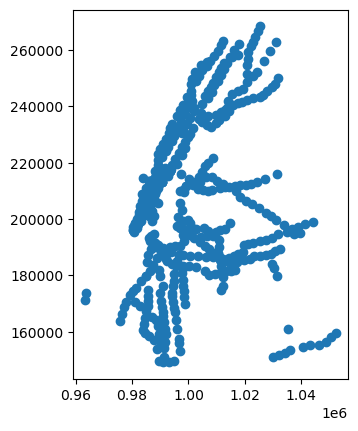

In [216]:
### Take a look at the shape
mta_compressed_geom.plot()

#### 2.3.2 Processing Citi Bike Data

##### a. Importing Data

In [229]:
### Read the Citi Bike records from the original CSV file
citi = pd.read_csv('Data/Citibike/Citibike_2022_Sep_RAW/202209-citibike-tripdata.csv',low_memory=False)

In [230]:
### Take a look at the data
citi.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,42B9E1161E021F66,classic_bike,2022-09-17 16:06:45,2022-09-17 16:18:03,Henry St & Degraw St,4380.08,7 Ave & Park Pl,4125.07,40.684736,-73.999088,40.677615,-73.973243,member
1,FE5FB109CA0FB68B,classic_bike,2022-09-25 14:26:25,2022-09-25 14:39:43,6 Ave & W 34 St,6364.10,W 50 St & 9 Ave,6854.05,40.749640,-73.988050,40.763605,-73.989180,member
2,D4E9E27DCE9CC556,classic_bike,2022-09-15 13:25:37,2022-09-15 13:51:35,6 Ave & W 34 St,6364.10,5 Ave & E 78 St,7161.08,40.749640,-73.988050,40.776321,-73.964274,member
3,757BFFFB009E8D21,classic_bike,2022-09-16 18:46:33,2022-09-16 18:52:42,48 St & 5 Ave,3202.06,36 St & 4 Ave,3420.01,40.646351,-74.009271,40.654144,-74.004220,member
4,4E6360AD2986736E,classic_bike,2022-09-10 09:20:56,2022-09-10 09:30:20,Steinway St & Ditmars Blvd,7074.01,Crescent St & 30 Ave,6958.06,40.772621,-73.906240,40.768692,-73.924957,member


In [231]:
### Convert the date and time in str format into timestamp
def date_convert_citi(date_to_convert):
     return time.mktime(datetime.strptime(date_to_convert, "%Y-%m-%d %H:%M:%S").timetuple())

citi['start_timestamp'] = citi['started_at'].apply(date_convert_citi)
citi['end_timestamp'] = citi['ended_at'].apply(date_convert_citi)

In [232]:
### Calculate the duration of each trip (in second)
citi['duration'] = citi['end_timestamp'] - citi['start_timestamp']

In [233]:
### Round time into hours,and avoid '24:00'
citi['start_time'] = citi['start_timestamp'].apply(get_hour)
citi['end_time'] = citi['end_timestamp'].apply(get_hour)
citi.loc[citi['start_time']==24,'start_time'] = 0
citi.loc[citi['end_time']==24,'end_time'] = 0
citi.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_timestamp,end_timestamp,duration,start_time,end_time
0,42B9E1161E021F66,classic_bike,2022-09-17 16:06:45,2022-09-17 16:18:03,Henry St & Degraw St,4380.08,7 Ave & Park Pl,4125.07,40.684736,-73.999088,40.677615,-73.973243,member,1.663445e+09,1.663446e+09,678.0,16,16
1,FE5FB109CA0FB68B,classic_bike,2022-09-25 14:26:25,2022-09-25 14:39:43,6 Ave & W 34 St,6364.10,W 50 St & 9 Ave,6854.05,40.749640,-73.988050,40.763605,-73.989180,member,1.664130e+09,1.664131e+09,798.0,14,15
2,D4E9E27DCE9CC556,classic_bike,2022-09-15 13:25:37,2022-09-15 13:51:35,6 Ave & W 34 St,6364.10,5 Ave & E 78 St,7161.08,40.749640,-73.988050,40.776321,-73.964274,member,1.663263e+09,1.663264e+09,1558.0,13,14
3,757BFFFB009E8D21,classic_bike,2022-09-16 18:46:33,2022-09-16 18:52:42,48 St & 5 Ave,3202.06,36 St & 4 Ave,3420.01,40.646351,-74.009271,40.654144,-74.004220,member,1.663368e+09,1.663369e+09,369.0,19,19
4,4E6360AD2986736E,classic_bike,2022-09-10 09:20:56,2022-09-10 09:30:20,Steinway St & Ditmars Blvd,7074.01,Crescent St & 30 Ave,6958.06,40.772621,-73.906240,40.768692,-73.924957,member,1.662816e+09,1.662817e+09,564.0,9,9


##### b. Data Cleaning: Removing Extreme Values and Weekends

(array([0., 0., 0., ..., 1., 4., 5.]),
 array([-500., -499., -498., ..., 7997., 7998., 7999.]),
 <BarContainer object of 8499 artists>)

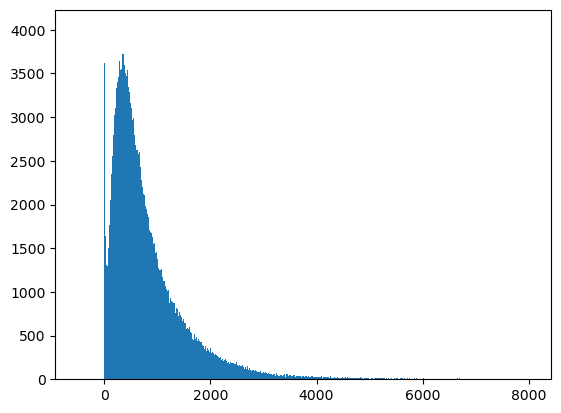

In [240]:
### Have a look at the shape of the raw data
plt.hist(citi.duration,bins=range(-500,8000))

By the histogram above, we can tell the data has a long-tail distributation, and choose trips of which the duration lies between 1 minute (60s) and 1.5 hours (5400s) seems to be reasonable.

In [244]:
### Remove those records doesn't match the criteria
citi = citi[(citi['duration'] >= 60) & (citi['duration'] <= 5400)]

(array([0., 0., 0., ..., 0., 0., 0.]),
 array([0.000e+00, 1.000e+00, 2.000e+00, ..., 5.997e+03, 5.998e+03,
        5.999e+03]),
 <BarContainer object of 5999 artists>)

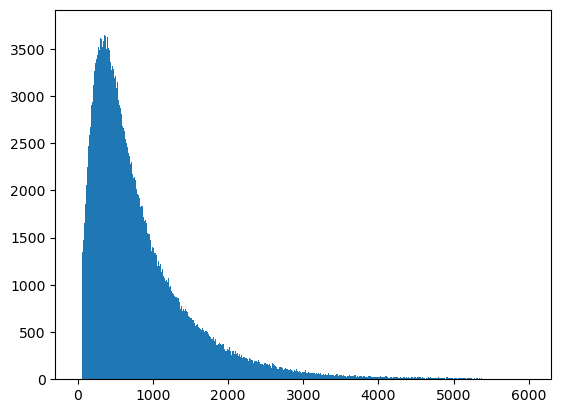

In [246]:
### Have a look at the shape of the filtered data
plt.hist(citi.duration,bins=range(0,6000))

In [247]:
### Removing weekends
citi = citi[(citi['start_timestamp'].apply(lambda x: time.localtime(x).tm_wday)!=5) & (citi['start_timestamp'].apply(lambda x: time.localtime(x).tm_wday)!=6)]

##### c. Add Geom Data to Citi Bike Records

In [251]:
### Create the geom of start locations
citi_geom_start = gpd.GeoDataFrame(citi, 
                                geometry=gpd.points_from_xy(citi['start_lng'], citi['start_lat']),
                                crs='EPSG:4326')
citi_geom_start = citi_geom_start.to_crs(2263)
### Create the geom of end locations
citi_geom_end = gpd.GeoDataFrame(citi, 
                                geometry=gpd.points_from_xy(citi['end_lng'], citi['end_lat']),
                                crs='EPSG:4326')
citi_geom_end = citi_geom_end.to_crs(2263)

<AxesSubplot: >

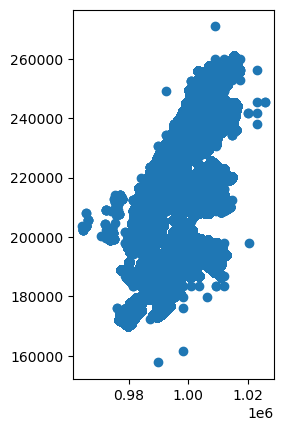

In [253]:
citi_geom_end.plot()

## 3. Results and Discussion


### 3.1 Graphical Representation of Both Services


### 3.2 Spatiotemporal Variation of the Relationship


### 3.3 Impacting Factors of the Relationship

Spatial Autocorrelation: SLX, spatial lag, or spatial error?

## 4. Conclusion and Future Research

## References
AitBihiOuali, L., & Klingen, J. (2022). Inclusive roads in NYC: Gender differences in responses to cycling infrastructure. *Cities, 127*, 103719. https://doi.org/10.1016/j.cities.2022.103719

*Citi Bike System Data | Citi Bike NYC.* (n.d.). Retrieved March 31, 2023, from https://citibikenyc.com/system-data

Cui, Y., Chen, X., Chen, X., & Zhang, C. (2023). Competition, Integration, or Complementation? Exploring Dock-Based Bike-Sharing in New York City. *The Professional Geographer, 75*(1), 65–75. https://doi.org/10.1080/00330124.2022.2081224

DeMaio, P. (2009). Bike-sharing: History, Impacts, Models of Provision, and Future. *Journal of Public Transportation, 12*(4), 41–56. https://doi.org/10.5038/2375-0901.12.4.3

Faghih-Imani, A., & Eluru, N. (2016). Incorporating the impact of spatio-temporal interactions on bicycle sharing system demand: A case study of New York CitiBike system. *Journal of Transport Geography, 54*, 218–227. https://doi.org/10.1016/j.jtrangeo.2016.06.008

Guo, Y., Yang, L., & Chen, Y. (2022). Bike Share Usage and the Built Environment: A Review. *Frontiers in Public Health, 10*, 848169. https://doi.org/10.3389/fpubh.2022.848169

Hamad, S. Y. Y., Ma, T., & Antoniou, C. (2021). Analysis and Prediction of Bikesharing Traffic Flow – Citi Bike, New York. *2021 7th International Conference on Models and Technologies for Intelligent Transportation Systems (MT-ITS)*, 1–8. https://doi.org/10.1109/MT-ITS49943.2021.9529290

Kong, H., Zhang, X., & Zhao, J. (2020). How does ridesourcing substitute for public transit? A geospatial perspective in Chengdu, China. *Journal of Transport Geography, 86*, 102769. https://doi.org/10.1016/j.jtrangeo.2020.102769

Kranish, C. (2021a, March 22). *Use Weather History with NYC Bike Share Trip Data*. Medium. https://towardsdatascience.com/use-weather-history-with-nyc-bike-share-trip-data-51fcb89297d

Kranish, C. (2021b, March 29). *Reverse Geocoding with NYC Bike Share Data*. Medium. https://towardsdatascience.com/reverse-geocoding-with-nyc-bike-share-data-cdef427987f8

Kranish, C. (2021c, April 4). *Visualizing NYC Bike Share Trips with a Chord Diagram*. Medium. https://towardsdatascience.com/visualizing-nyc-bike-share-trips-with-a-chord-diagram-eb4c8e14366

Kranish, C. (2021d, April 8). *Exploring the Effects of the Pandemic on NYC Bike Share Usage*. Medium. https://towardsdatascience.com/exploring-the-effects-of-the-pandemic-on-nyc-bike-share-usage-ab79f67ac2df

Kranish, C. (2021e, April 9). *Estimating Bike Availability from NYC Bike Share Data*. Medium. https://towardsdatascience.com/estimating-bike-availability-from-nyc-bike-share-data-7cfc4655d5f6

Kranish, C. (2021f, April 13). *Interpolating NYC Bike Share Data to Discover Rebalancing Movements*. Medium. https://towardsdatascience.com/interpolating-nyc-bike-share-data-to-discover-rebalancing-movements-6cf8a80eb902

Kranish, C. (2021g, May 14). *Exploring Bike Share Data*. Medium. https://towardsdatascience.com/exploring-bike-share-data-3e3b2f28760c

Mix, R., Hurtubia, R., & Raveau, S. (2022). Optimal location of bike-sharing stations: A built environment and accessibility approach. *Transportation Research Part A: Policy and Practice, 160*, 126–142. https://doi.org/10.1016/j.tra.2022.03.022

New York City Department of Transportation. 2019. New York City mobility report. Accessed 18 May 2023. https://www.nyc.gov/html/dot/downloads/pdf/mobility-report-singlepage-2019.pdf.

Wang, W. (2016). Forecasting Bike Rental Demand Using New York Citi Bike Data. *Dissertations*. https://arrow.tudublin.ie/scschcomdis/79

Whong, C. (2020, June 19). Taming the MTA’s Unruly Turnstile Data. *Qri.Io*. https://medium.com/qri-io/taming-the-mtas-unruly-turnstile-data-c945f5f96ba0

Xin, R., Ding, L., Ai, B., Yang, M., Zhu, R., Cao, B., & Meng, L. (2023). Geospatial Network Analysis and Origin-Destination Clustering of Bike-Sharing Activities during the COVID-19 Pandemic. *ISPRS International Journal of Geo-Information, 12*(1), Article 1. https://doi.org/10.3390/ijgi12010023

Yamane, T., & Kaneko, S. (2021). Is the younger generation a driving force toward achieving the sustainable development goals? Survey experiments. *Journal of Cleaner Production, 292*, 125932. https://doi.org/10.1016/j.jclepro.2021.125932

Zhang, L., Xiao, Z., Ren, S., Qin, Z., Goh, R. S. M., & Song, J. (2022). Measuring the vulnerability of bike-sharing system. *Transportation Research Part A: Policy and Practice, 163*, 353–369. https://doi.org/10.1016/j.tra.2022.05.019